## 2-Layer neural network

In [19]:
import numpy as np
import pandas as pd
from scipy.special import softmax
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [20]:
# basic
class TwoLayersNeuralNet:
    
    def __init__(self, n_in, n_hidden, n_out):
        # set class params
        self.n_in = n_in
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.losses = []
        
        # init weight and bias
        self.W2 = np.random.randn(n_hidden,n_in) * 0.5
        self.b2 = np.zeros((n_hidden,1))
        self.W3 = np.random.randn(n_out,n_hidden) * 0.5
        self.b3 = np.zeros((n_out,1))
        
    def train(
        self, 
        X, 
        Y, 
        n_iteration, 
        learning_rate, 
        n_batch=None):
        
        for i in range(n_iteration):
            # define samples to use in this epoch's training
            batch_X, batch_Y = self._batch(X, Y, n_batch)
            
            # forward propagation
            U2, Z2, U3, Z3 = self._forward(batch_X)
            
            # compute error
            loss = self._loss(Z3, batch_Y)
            self.losses.append(loss)
            
            # backward propagation
            dW2, db2, dW3, db3 = self._backward(batch_X, batch_Y, Z2, Z3)
            
            # update weights and biases
            self._update(dW2, db2, dW3, db3, learning_rate)
            
            # print progress
            if i % 100 == 0:
                print ("Loss after iteration %i: %f" %(i, loss))
                
    # prediction
    def predict(self, X):
        N = X.shape[1] # number of samples to predict
        
        # forward propagation
        U2, Z2, U3, Z3 = self._forward(X)
        
        # empty array to fill the prediction
        Y_pred = np.zeros((self.n_out, N))
        
        # prediction
        max_indices = np.argmax(Z3, axis = 0)
        
        for i in range(N):
            Y_pred[max_indices[i],i] = 1
        
        return Y_pred
                
    # ---------- internal functions ---------- 
            
    def _batch(self, X, Y, n_batch):
        if n_batch is None:
            return X,Y
        else:
            batch_indices = np.random.choice(range(X.shape[1]),n_batch,replace=False)
            return X[:,batch_indices], Y[:,batch_indices]
    
    def _forward(self, X):
        # hidden layer
        U2 = np.dot(self.W2,X) + self.b2
        Z2 = np.tanh(U2)
        
        # output layer
        U3 = np.dot(self.W3,Z2) + self.b3
        Z3 = softmax(U3, axis=0)
        
        return U2, Z2, U3, Z3
    
    def _loss(self, Z3, Y):
        N = Y.shape[1] # number of samples used in this training
        
        cross_entropy = np.multiply(np.log(Z3),Y)
        loss = -np.sum(cross_entropy)/N
        
        return loss
    
    def _backward(self, X, Y, Z2, Z3):
        N = X.shape[1] # number of samples used in this training
        
        # output layer
        dU3 = Z3 - Y
        dW3 = np.dot(dU3,Z2.T)/N
        db3 = np.sum(dU3,axis =1,keepdims=True)/N
        
        # hidden layer
        dZ2 = 1 - np.power(Z2, 2) # (tanh(u))' = 1 - tanh^2(u)
        dU2 = np.dot(self.W3.T,dU3)*dZ2
        dW2 = np.dot(dU2,X.T)/N
        db2 = np.sum(dU2,axis =1,keepdims=True)/N
        
        return dW2, db2, dW3, db3
    
    def _update(self, dW2, db2, dW3, db3, learning_rate):
        # hidden layer
        self.W2 = self.W2 - learning_rate*dW2
        self.b2 = self.b2 - learning_rate*db2
        
        # output layer
        self.W3 = self.W3 - learning_rate*dW3
        self.b3 = self.b3 - learning_rate*db3
    

In [37]:
# with regularization and momentum
class TwoLayersNeuralNetRegularized(TwoLayersNeuralNet):
    
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__(n_in, n_hidden, n_out)
        
        # for momentum
        self.delta_W2 = 0
        self.delta_b2 = 0
        self.delta_W3 = 0
        self.delta_b3 = 0
        
    def train(
        self, 
        X, 
        Y, 
        n_iteration, 
        learning_rate,
        lambda_l2=0,
        momentum=0,
        n_batch=None):
        
        for i in range(n_iteration):
            # define samples to use in this epoch's training
            batch_X, batch_Y = self._batch(X, Y, n_batch)
            
            # forward propagation
            U2, Z2, U3, Z3 = self._forward(batch_X)
            
            # compute error
            loss = self._loss(Z3, batch_Y, lambda_l2)
            self.losses.append(loss)
            
            # backward propagation
            dW2, db2, dW3, db3 = self._backward(batch_X, batch_Y, Z2, Z3)
            
            # update weights and biases
            self._update(dW2, db2, dW3, db3, learning_rate, lambda_l2, momentum)
            
            # print progress
            if i % 100 == 0:
                print ("Loss after iteration %i: %f" %(i, loss))
                
    # ---------- internal functions ---------- 
    
    def _loss(self, Z3, Y, lambda_l2):
        N = Y.shape[1] # number of samples used in this training
        
        cross_entropy = np.multiply(np.log(Z3),Y)
        loss = -np.sum(cross_entropy)/N + (lambda_l2/2.0)*((self.W2*self.W2).sum()+(self.W3*self.W3).sum())
        
        return loss
    
    def _update(self, dW2, db2, dW3, db3, learning_rate, lambda_l2, momentum):
        # hidden layer
        self.delta_W2 = - learning_rate * (dW2 + lambda_l2*self.W2) + momentum * self.delta_W2
        self.W2 = self.W2 + self.delta_W2
        
        self.delta_b2 = - learning_rate * db2 + momentum * self.delta_b2
        self.b2 = self.b2 + self.delta_b2
        
        # output layer
        self.delta_W3 = - learning_rate * (dW3 + lambda_l2*self.W3) + momentum * self.delta_W3
        self.W3 = self.W3 + self.delta_W3
        
        self.delta_b3 = - learning_rate * db3 + momentum * self.delta_b3
        self.b3 = self.b3 + self.delta_b3
    

#### Run

In [28]:
# load data
X_raw = np.load('../../input/Sign-language-digits-dataset/X.npy')
Y_raw = np.load('../../input/Sign-language-digits-dataset/Y.npy')

# check data shape
print(X_raw.shape)
print(Y_raw.shape)

(2062, 64, 64)
(2062, 10)


(-0.5, 63.5, 63.5, -0.5)

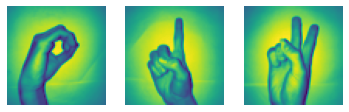

In [27]:
# see data samples
img_size = 64
plt.subplot(1, 3, 1)
plt.imshow(X_raw[260].reshape(img_size, img_size))
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(X_raw[900].reshape(img_size, img_size))
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(X_raw[1800].reshape(img_size, img_size))
plt.axis('off')

In [31]:
# split data into training & test data
X_train_raw, X_test_raw, Y_train_raw, Y_test_raw = train_test_split(X_raw, Y_raw, test_size=0.15, random_state=42)
number_of_train = X_train_raw.shape[0]
number_of_test = X_test_raw.shape[0]

# check the data shape
print("X train raw",X_train_raw.shape)
print("X test raw",X_test_raw.shape)

X train raw (1752, 64, 64)
X test raw (310, 64, 64)


In [33]:
# flatten the data (3 dim -> 2 dim)
X_train_flatten = X_train_raw.reshape(number_of_train,X_train_raw.shape[1]*X_train_raw.shape[2])
X_test_flatten = X_test_raw.reshape(number_of_test,X_test_raw.shape[1]*X_test_raw.shape[2])

# check the data shape
print("X train flatten",X_train_flatten.shape)
print("X test flatten",X_test_flatten.shape)

X train flatten (1752, 4096)
X test flatten (310, 4096)


In [34]:
# transpose to fit the model input
X_train = X_train_flatten.T
X_test = X_test_flatten.T
Y_train = Y_train_raw.T
Y_test = Y_test_raw.T

# check the final input data shape
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",Y_train.shape)
print("y test: ",Y_test.shape)

x train:  (4096, 1752)
x test:  (4096, 310)
y train:  (10, 1752)
y test:  (10, 310)


In [38]:
NN = TwoLayersNeuralNetRegularized(4096, 100, 10)

In [39]:
NN.train(X_train, Y_train, n_iteration=10000, learning_rate=0.02, lambda_l2=0.001,
        momentum=0.5, n_batch=500)

Loss after iteration 0: 59.362790
Loss after iteration 100: 53.259267
Loss after iteration 200: 52.787609
Loss after iteration 300: 52.297988
Loss after iteration 400: 51.824421
Loss after iteration 500: 51.346298
Loss after iteration 600: 50.859914
Loss after iteration 700: 50.400994
Loss after iteration 800: 49.928219
Loss after iteration 900: 49.424956
Loss after iteration 1000: 49.031093
Loss after iteration 1100: 48.557872
Loss after iteration 1200: 48.186978
Loss after iteration 1300: 47.749487
Loss after iteration 1400: 47.292835
Loss after iteration 1500: 46.952813
Loss after iteration 1600: 46.544128
Loss after iteration 1700: 46.130960
Loss after iteration 1800: 45.698496
Loss after iteration 1900: 45.386702
Loss after iteration 2000: 44.943573
Loss after iteration 2100: 44.604689
Loss after iteration 2200: 44.287809
Loss after iteration 2300: 43.887351
Loss after iteration 2400: 43.562202
Loss after iteration 2500: 43.121496
Loss after iteration 2600: 42.741526
Loss after it

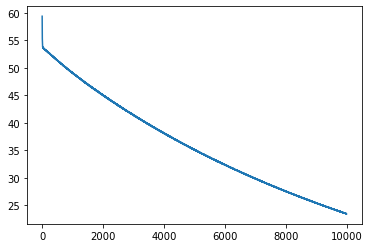

In [40]:
plt.plot(NN.losses)

In [41]:
# predict
Y_pred_test = NN.predict(X_test)
Y_pred_train = NN.predict(X_train)

print("train accuracy: {} %".format(100 - np.mean(np.sum(abs(Y_pred_train - Y_train),axis=0)/2) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.sum(abs(Y_pred_test - Y_test),axis=0)/2) * 100))

train accuracy: 94.46347031963471 %
test accuracy: 64.19354838709677 %
